In [1]:
#working with classification on pytorch
import torch
from torch import nn
import matplotlib.pyplot as plt

In [2]:
#making a toy classification dataset
import sklearn
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(X[:5])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]


In [5]:
print(y[:5])

[1 1 1 1 0]


In [6]:
import pandas as pd

df = pd.DataFrame({'X1:': X[:, 0],
                   'X2': X[:, 1],
                   'label': y})

In [7]:
df.head()

,X1:,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


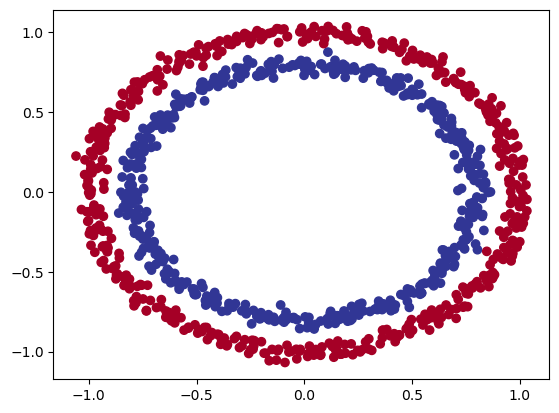

In [8]:
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.show()

In [9]:
#turning data into tensors

X.shape, y.shape

((1000, 2), (1000,))

In [10]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [11]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [12]:
type(X), type(y)

(torch.Tensor, torch.Tensor)

In [13]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [16]:
#setting up device agnostic code

device = 'mps' if torch.mps.is_available() else 'cpu'
device

'mps'

In [17]:
#creating a model
class ClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.two_linear_layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=8),
            nn.Linear(in_features=8, out_features=1)
        )

    def forward(self, x):
        return self.two_linear_layers(x)

model = ClassificationModel().to(device)
model


ClassificationModel(
  (two_linear_layers): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [18]:
next(model.parameters()).device

device(type='mps', index=0)

In [19]:
model.state_dict()

OrderedDict([('two_linear_layers.0.weight',
              tensor([[ 0.0908,  0.6045],
                      [ 0.0447, -0.0594],
                      [ 0.1150,  0.2130],
                      [ 0.0129, -0.6806],
                      [ 0.1367,  0.5753],
                      [ 0.3957, -0.5309],
                      [ 0.1461,  0.1911],
                      [-0.5173, -0.6736]], device='mps:0')),
             ('two_linear_layers.0.bias',
              tensor([ 0.5102,  0.0141,  0.6052, -0.2161,  0.6904, -0.5270,  0.3672, -0.4489],
                     device='mps:0')),
             ('two_linear_layers.1.weight',
              tensor([[ 0.0755, -0.2864,  0.1261,  0.2405, -0.0214,  0.1960,  0.0565,  0.3125]],
                     device='mps:0')),
             ('two_linear_layers.1.bias', tensor([0.1969], device='mps:0'))])

In [20]:
#make predictions
with torch.inference_mode():
    untrained_preds = model(X_test.to(device))
print(f'Length: {len(untrained_preds)}, Shape: {untrained_preds.shape}')
print(f'Length: {len(X_test)}, Shape: {X_test.shape}')
print(f'First 10 predictions: {torch.round(untrained_preds[:10])}')
print(f'First 10 labels: {y_test[:10]}')

Length: 200, Shape: torch.Size([200, 1])
Length: 200, Shape: torch.Size([200, 2])
First 10 predictions: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='mps:0')
First 10 labels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [21]:
#setting up a loss function and optimizers
loss_fn = nn.BCEWithLogitsLoss()
loss_fn

BCEWithLogitsLoss()

In [22]:
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [23]:
#calculate accuracy
def accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

In [24]:
#training our model
#going from raw logits to prediction probabilities
model.eval()
with torch.inference_mode():
    y_logits = model(X_test.to(device))[:5]
y_logits

tensor([[-0.2231],
        [-0.3576],
        [ 0.1881],
        [-0.3399],
        [ 0.2814]], device='mps:0')

In [25]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [26]:
y_pred_prob = torch.sigmoid(y_logits)
y_pred_prob

tensor([[0.4444],
        [0.4115],
        [0.5469],
        [0.4158],
        [0.5699]], device='mps:0')

In [27]:
y_preds = torch.round(y_pred_prob)
y_pred_labels = torch.round(torch.sigmoid(model(X_test.to(device))[:5]))
print(torch.eq(y_preds.squeeze(),y_pred_labels.squeeze()))
y_preds.squeeze()

tensor([True, True, True, True, True], device='mps:0')


tensor([0., 0., 1., 0., 1.], device='mps:0')

In [28]:
torch.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model.train()
    y_logits_1 = model(X_train).squeeze()
    y_pred_1 = torch.round(torch.sigmoid(y_logits_1))
    loss = loss_fn(y_logits_1, y_train)
    acc = accuracy(y_true=y_train, y_pred=y_pred_1)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model.eval()
    with torch.inference_mode():
        y_logits_test = model(X_test).squeeze()
        y_pred_test = torch.round(torch.sigmoid(y_logits_test))
        test_loss = loss_fn(y_logits_test, y_test)
        test_acc = accuracy(y_true=y_test, y_pred=y_pred_test)

    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f} | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}')

Epoch: 0 | Loss: 0.70341, Accuracy: 49.62 | Test Loss: 0.69240, Test Accuracy: 53.00
Epoch: 10 | Loss: 0.70301, Accuracy: 49.50 | Test Loss: 0.69222, Test Accuracy: 54.00
Epoch: 20 | Loss: 0.70265, Accuracy: 49.75 | Test Loss: 0.69207, Test Accuracy: 54.00
Epoch: 30 | Loss: 0.70232, Accuracy: 49.38 | Test Loss: 0.69194, Test Accuracy: 53.50
Epoch: 40 | Loss: 0.70201, Accuracy: 49.50 | Test Loss: 0.69183, Test Accuracy: 54.00
Epoch: 50 | Loss: 0.70171, Accuracy: 49.50 | Test Loss: 0.69174, Test Accuracy: 53.50
Epoch: 60 | Loss: 0.70144, Accuracy: 49.00 | Test Loss: 0.69165, Test Accuracy: 54.50
Epoch: 70 | Loss: 0.70119, Accuracy: 49.38 | Test Loss: 0.69158, Test Accuracy: 54.50
Epoch: 80 | Loss: 0.70094, Accuracy: 49.38 | Test Loss: 0.69151, Test Accuracy: 54.50
Epoch: 90 | Loss: 0.70071, Accuracy: 49.50 | Test Loss: 0.69146, Test Accuracy: 54.50
Epoch: 100 | Loss: 0.70050, Accuracy: 49.25 | Test Loss: 0.69141, Test Accuracy: 55.00
Epoch: 110 | Loss: 0.70029, Accuracy: 49.38 | Test Los

In [29]:
#getting visual

import requests
from pathlib import Path
if Path('helper_functions.py').is_file():
    print('helper_functions.py already exists')
else:
    print('Downloading')
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    with open('helper_functions.py', 'wb') as f:
        f.write(request.content)
from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists


/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

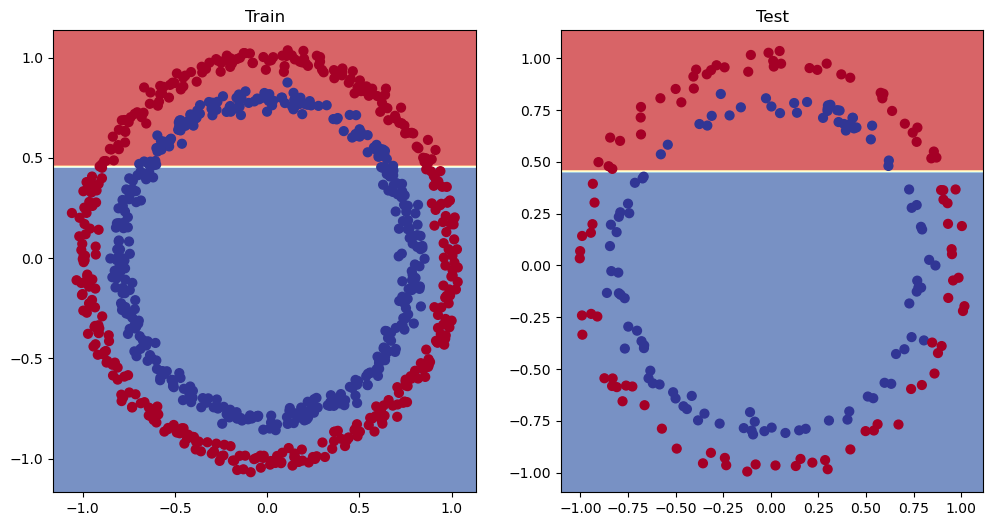

In [30]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model, X_test, y_test)

In [31]:
#improving a model

#add more layers/hidden units/fit for longer/changing the activation functions/change the lr/change loss function

model.state_dict()

OrderedDict([('two_linear_layers.0.weight',
              tensor([[ 0.0961,  0.6339],
                      [ 0.0317, -0.1306],
                      [ 0.1203,  0.2422],
                      [ 0.0206, -0.6389],
                      [ 0.1372,  0.5782],
                      [ 0.4033, -0.4894],
                      [ 0.1489,  0.2062],
                      [-0.5064, -0.6139]])),
             ('two_linear_layers.0.bias',
              tensor([ 0.4936,  0.0528,  0.5896, -0.2375,  0.6883, -0.5491,  0.3590, -0.4801])),
             ('two_linear_layers.1.weight',
              tensor([[ 0.1626, -0.3116,  0.1086,  0.1131,  0.0334,  0.1609,  0.0636,  0.1965]])),
             ('two_linear_layers.1.bias', tensor([0.0675]))])

In [32]:
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=16)
        self.layer2 = nn.Linear(in_features=16, out_features=24)
        self.layer3 = nn.Linear(in_features=24, out_features=1)
    
    def forward(self, x):
        # z = self.layer1(x)
        # z = self.layer2(z)
        # z = self.layer3(z)
        return self.layer3(self.layer2(self.layer1(x)))

model_0 = CircleModel().to(device)
model_0

CircleModel(
  (layer1): Linear(in_features=2, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=24, bias=True)
  (layer3): Linear(in_features=24, out_features=1, bias=True)
)

In [34]:
#create a loss function

criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.1)

In [41]:
torch.manual_seed(42)
torch.mps.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
    model_0.train()
    y_logits_0 = model_0(X_train).squeeze()
    y_preds_0 = torch.round(torch.sigmoid(y_logits_0))
    loss = criterion(y_logits_0, y_train)
    acc = accuracy(y_train, y_preds_0)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.inference_mode():
        y_logits_test_0 = model_0(X_test).squeeze()
        y_preds_test_0 = torch.round(torch.sigmoid(y_logits_test_0))
        test_loss_0 = criterion(y_logits_test_0, y_test)
        acc = accuracy(y_test, y_preds_test_0)
        
    if epoch % 100 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f} | Loss Test: {test_loss:.5f} | Accuracy Test: {test_acc:.2f}')

Epoch: 0 | Loss: 0.69298 | Accuracy: 46.00 | Loss Test: 0.69203 | Accuracy Test: 54.50
Epoch: 100 | Loss: 0.69298 | Accuracy: 46.00 | Loss Test: 0.69203 | Accuracy Test: 54.50
Epoch: 200 | Loss: 0.69298 | Accuracy: 46.00 | Loss Test: 0.69203 | Accuracy Test: 54.50
Epoch: 300 | Loss: 0.69298 | Accuracy: 46.00 | Loss Test: 0.69203 | Accuracy Test: 54.50
Epoch: 400 | Loss: 0.69298 | Accuracy: 46.00 | Loss Test: 0.69203 | Accuracy Test: 54.50
Epoch: 500 | Loss: 0.69303 | Accuracy: 47.50 | Loss Test: 0.69203 | Accuracy Test: 54.50
Epoch: 600 | Loss: 0.69298 | Accuracy: 46.00 | Loss Test: 0.69203 | Accuracy Test: 54.50
Epoch: 700 | Loss: 0.69298 | Accuracy: 46.00 | Loss Test: 0.69203 | Accuracy Test: 54.50
Epoch: 800 | Loss: 0.69298 | Accuracy: 46.00 | Loss Test: 0.69203 | Accuracy Test: 54.50
Epoch: 900 | Loss: 0.69298 | Accuracy: 46.00 | Loss Test: 0.69203 | Accuracy Test: 54.50


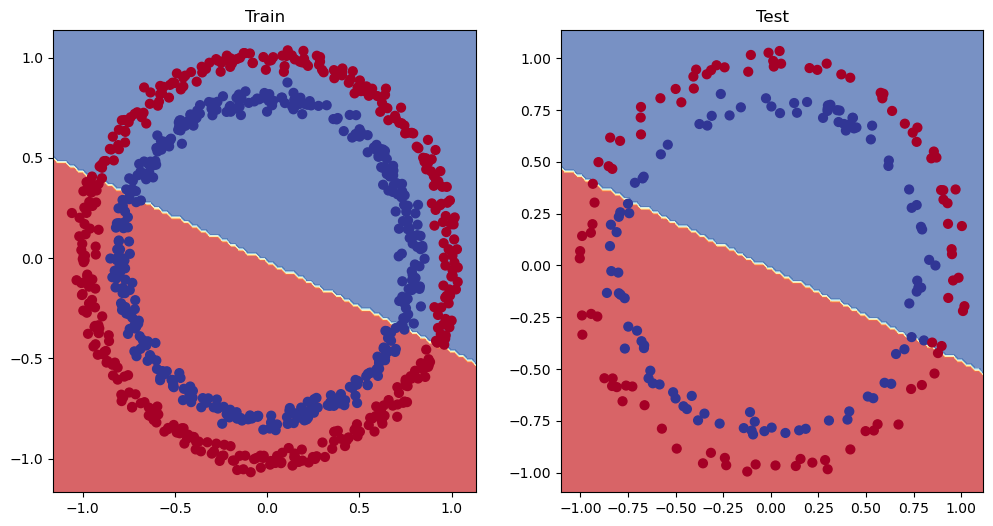

In [42]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_0, X_test, y_test)